## Import Libraries 


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('stopwords')
nltk.download('punkt')

from wordcloud import WordCloud
from datasets import load_dataset
# define the stemmer and stopwords
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))


from sklearn.metrics import recall_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
import random

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vilis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vilis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vilis\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Import dataset

In [2]:
data = load_dataset("yahoo_answers_topics.py")
#data = load_dataset("../../NLP_yahoo_questions/tools/yahoo_answers_topics/yahoo_answers_topics.py")

Found cached dataset yahoo_answers_topics (C:/Users/vilis/.cache/huggingface/datasets/yahoo_answers_topics/yahoo_answers_topics/1.0.0/0edb353eefe79d9245d7bd7cac5ae6af19530439da520d6dde1c206ee38f4439)


  0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
df_train = data['train'].to_pandas()
df_test = data['test'].to_pandas()

In [4]:
df_train.head()

,id,topic,question_title,question_content,best_answer
0,0,4,why doesn't an optical mouse work on a glass t...,or even on some surfaces?,Optical mice use an LED and a camera to rapidl...
1,1,5,What is the best off-road motorcycle trail ?,long-distance trail throughout CA,i hear that the mojave road is amazing!<br />\...
2,2,2,What is Trans Fat? How to reduce that?,I heard that tras fat is bad for the body. Wh...,Trans fats occur in manufactured foods during ...
3,3,6,How many planes Fedex has?,I heard that it is the largest airline in the ...,according to the www.fedex.com web site:\nAir ...
4,4,6,"In the san francisco bay area, does it make se...",the prices of rent and the price of buying doe...,renting vs buying depends on your goals. <br /...


## Preprocessing

In [5]:
# Converting integers to strings to understand each label independently.
categories = {0: 'Society & Culture', 1: 'Science & Mathematics', 2: 'Health', 3: 'Education & Reference',
              4: 'Computers & Internet', 5: 'Sports', 6: 'Business & Finance', 7: 'Entertainment & Music',
              8: 'Family & Relationships', 9: 'Politics & Government'}

In [6]:
# Mapping dict to target
df_train['topic_name'] = df_train['topic'].map(categories)
df_train.head(3) 

,id,topic,question_title,question_content,best_answer,topic_name
0,0,4,why doesn't an optical mouse work on a glass t...,or even on some surfaces?,Optical mice use an LED and a camera to rapidl...,Computers & Internet
1,1,5,What is the best off-road motorcycle trail ?,long-distance trail throughout CA,i hear that the mojave road is amazing!<br />\...,Sports
2,2,2,What is Trans Fat? How to reduce that?,I heard that tras fat is bad for the body. Wh...,Trans fats occur in manufactured foods during ...,Health


In [7]:
df_train.isna().sum()

id                  0
topic               0
question_title      0
question_content    0
best_answer         0
topic_name          0
dtype: int64

In [8]:
df_test.isna().sum()

id                  0
topic               0
question_title      0
question_content    0
best_answer         0
dtype: int64

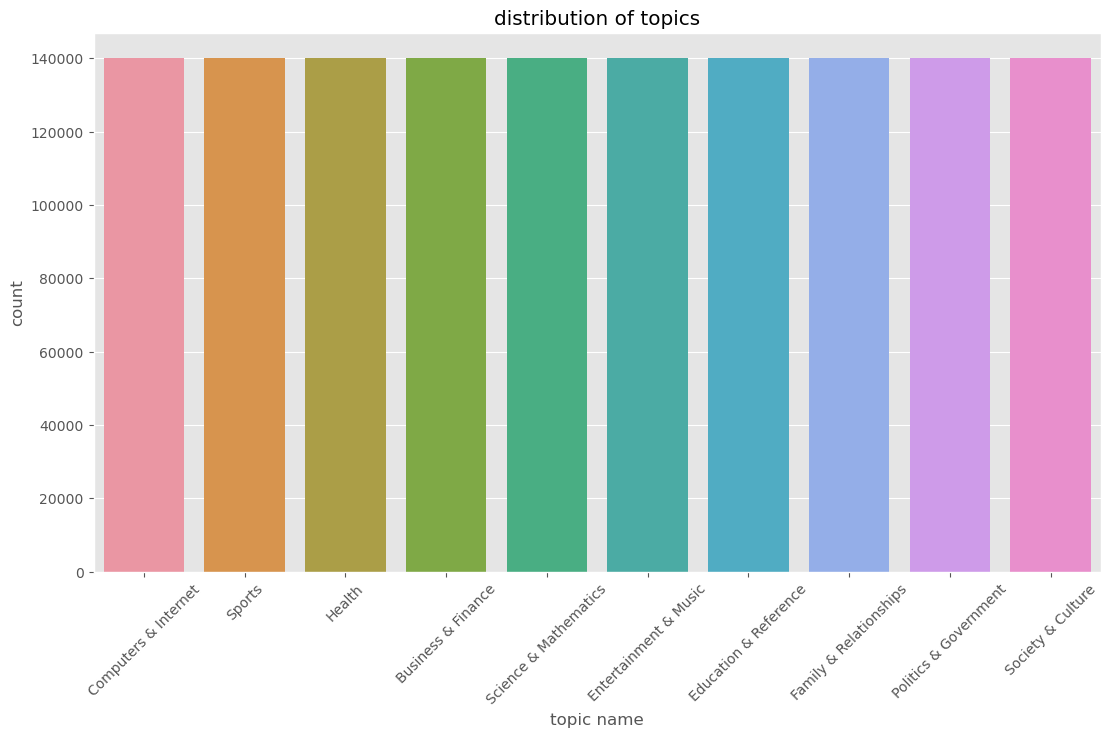

In [9]:
# Topic distribution 
plt.figure(figsize=(13, 7)) 
plt.style.use('ggplot')
sns.countplot(x = 'topic_name', data = df_train)
plt.title('distribution of topics', fontweight='bold')
plt.xlabel('topic name', fontweight='bold')
plt.xticks(rotation=45); 

##### Main conclusions

+ There are no null values
+ Topics are equally distributed
+ Since it's balanced, no need to do oversampling

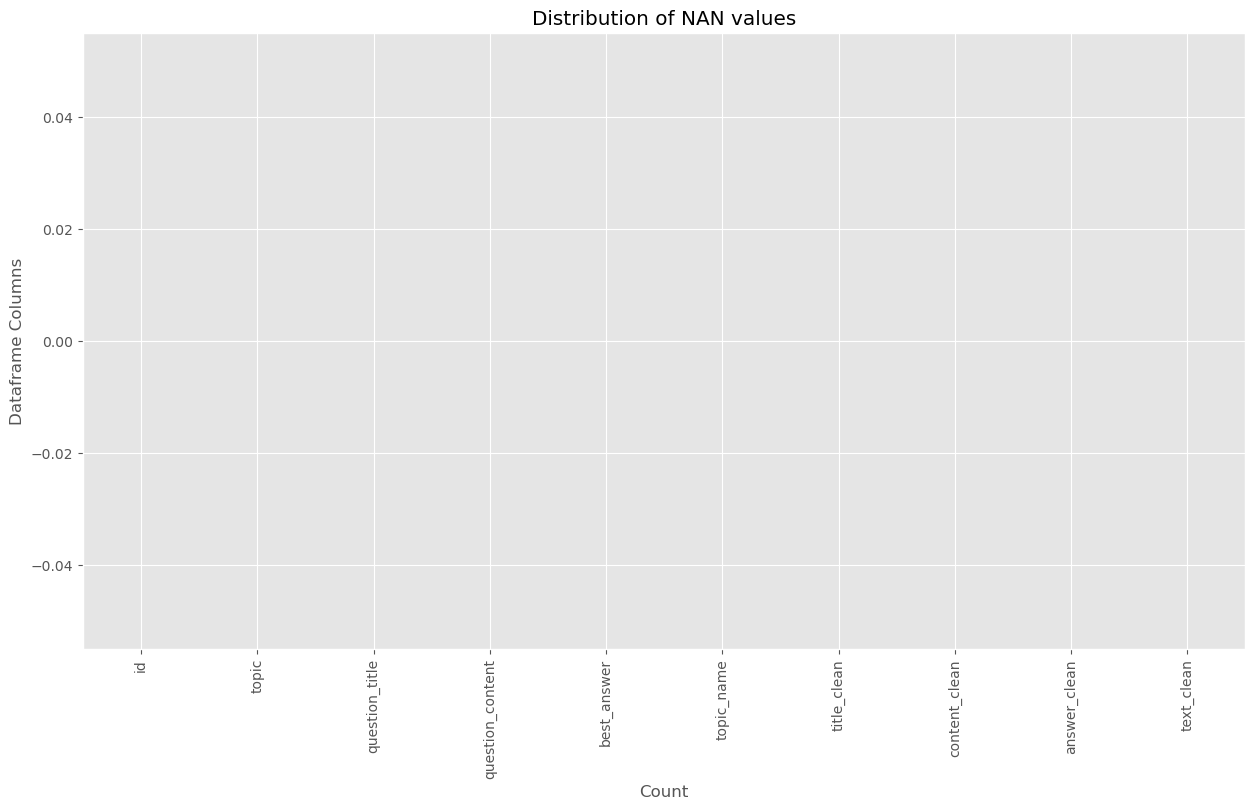

Missing data of training set
id                  0
topic               0
question_title      0
question_content    0
best_answer         0
topic_name          0
title_clean         0
content_clean       0
answer_clean        0
text_clean          0
dtype: int64


Missing data of test set
id                  0
topic               0
question_title      0
question_content    0
best_answer         0
dtype: int64


In [15]:
# Exploring NaN values in dataset
fig = plt.figure(figsize=(15, 8))
plt.title("Distribution of NAN values")
plt.xlabel('Count')
plt.ylabel('Dataframe Columns') 
df_train.isna().sum().sort_values(ascending = True).plot(kind = 'bar')
plt.show();

print("Missing data of training set")
print(df_train.isna().sum())
print("\n")
print("Missing data of test set")
print(df_test.isna().sum())

Insights from chart above: no data is missing

#### Preprocessing function

In [10]:
def preprocess_text(text):
    text = text.replace('\\n',' ').replace('<br />','')
    # tokenize the text into words
    tokens = nltk.word_tokenize(text.lower())
    # remove stopwords and punctuation
    filtered_tokens = [token for token in tokens if token not in stop_words and token not in string.punctuation]
    # perform stemming
    ##stemmed_tokens = [stemmer.stem(token) for token in filtered_tokens]
    # join the stemmed tokens back into a string
    ##preprocessed_text = ' '.join(stemmed_tokens)
    preprocessed_text = ' '.join(filtered_tokens)
    return preprocessed_text.replace('[^\w\s]', '')

In [11]:
df_train['title_clean'] = df_train['question_title'].apply(preprocess_text)

In [12]:
df_train['content_clean'] = df_train['question_content'].apply(preprocess_text)

In [13]:
df_train['answer_clean'] = df_train['best_answer'].apply(preprocess_text)

In [14]:
df_train['text_clean'] = df_train['title_clean'] + ' ' + df_train['content_clean'] + ' ' + df_train['answer_clean']

In [16]:
df_train.to_csv("yahoo_train.csv", index=False)

In [19]:
df_clean = df_train[['topic','topic_name','text_clean']]

In [20]:
df_clean = df_clean[df_clean.topic.isin([0,1,2])]

In [21]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 420000 entries, 2 to 1399998
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   topic       420000 non-null  int64 
 1   topic_name  420000 non-null  object
 2   text_clean  420000 non-null  object
dtypes: int64(1), object(2)
memory usage: 12.8+ MB


## Word cloud

+ Words with more ocurrences 

In [22]:
wordcloud = WordCloud(width=800, height=800, background_color='white', colormap='viridis', max_words=50)
df_train['title_clean'] = df_train['title_clean'].astype(str)

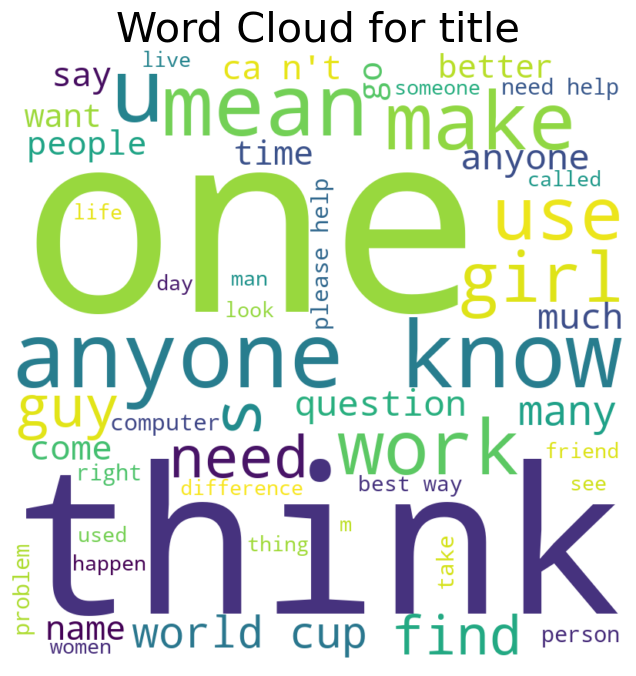

In [23]:
wordcloud_title = ' '.join(df_train['title_clean'])
wordcloud.generate(wordcloud_title)
# Plot the word cloud with a title
plt.figure(figsize=(8,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for title', fontsize=30)
plt.show()

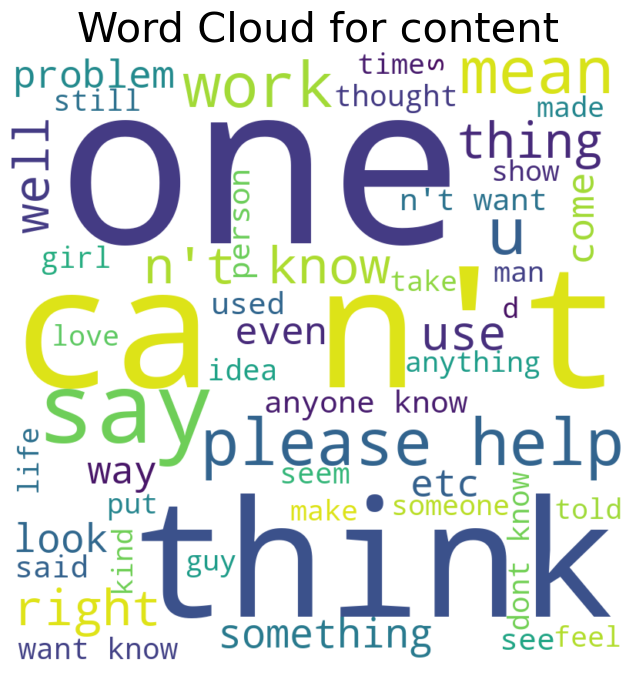

In [24]:
wordcloud_content = ' '.join(df_train['content_clean'])
wordcloud.generate(wordcloud_content)
plt.figure(figsize=(8,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for content', fontsize=30)
plt.show()

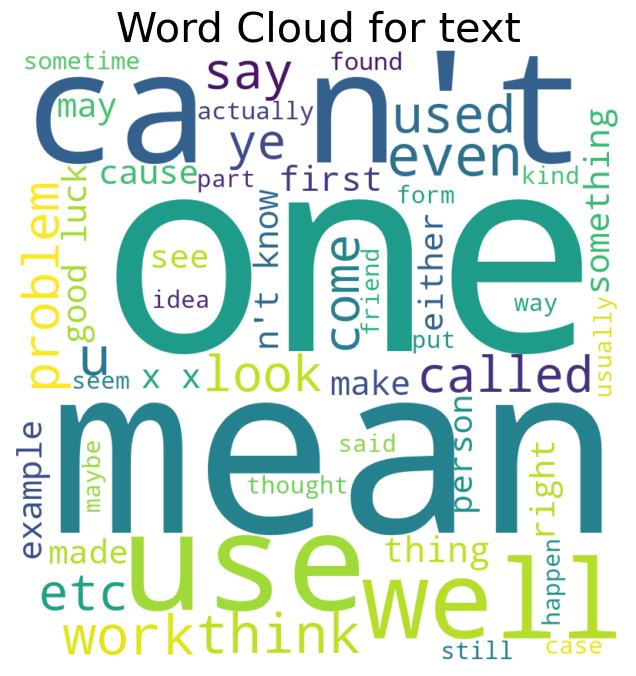

In [25]:
wordcloud_text = ' '.join(df_clean['text_clean'])
wordcloud.generate(wordcloud_text)
plt.figure(figsize=(8,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for text', fontsize=30)
plt.show()

In [28]:
import spacy

### Spacy tokenizer

In [30]:
#spaCy tokenizer

nlp = spacy.load("en_core_web_sm", exclude=["ner"])
"""
  Objective: get the tokenizer you want, and quit stop words
  inputs: 
    - nlp, spacy model: the spacy model to consider
    - texts, list of texts: the list of texts to tokenize
    - stop_words, list of stop_words to avoid
  outputs: 
    - tokens, list of lists of tokens: the list of all sentences tokenized
"""

stop_words=[]
def spacy_tokenizer(texts, stop_words, nlp=nlp):
    tokens=[]
    docs=nlp.pipe(texts)
    for doc in docs:
        _tokens=[tok.text for tok in doc if tok.text not in stop_words]
        tokens.append(_tokens)
    return tokens

### Apply the function to tokenize topic 0

In [46]:
tokens_0 = spacy_tokenizer(df_clean.loc[df_clean.loc[:, 'topic'] == 0, 'text_clean'].values,stop_words,nlp)

### Now we repeat for topics 1 and 2

In [37]:
tokens_1 = spacy_tokenizer(df_clean.loc[df_clean.loc[:, 'topic'] == 1, 'text_clean'].values,stop_words,nlp)
tokens_2 = spacy_tokenizer(df_clean.loc[df_clean.loc[:, 'topic'] == 2, 'text_clean'].values,stop_words,nlp)

In [40]:
#Un-nest list

tokens_0_flat = [word for sublist in tokens_0 for word in sublist]
tokens_1_flat = [word for sublist in tokens_1 for word in sublist]
tokens_2_flat = [word for sublist in tokens_1 for word in sublist]

In [33]:
#Counter words 

from collections import Counter

def most_common_words(words):
    word_counts = Counter(words)
    top_words = word_counts.most_common(50)
    return [word for word, count in top_words]

In [41]:
tokens_0_t50 = most_common_words(tokens_0_flat)
tokens_1_t50 = most_common_words(tokens_1_flat)
tokens_2_t50 = most_common_words(tokens_2_flat)

#### Print wordcloud for 50 common words by topic

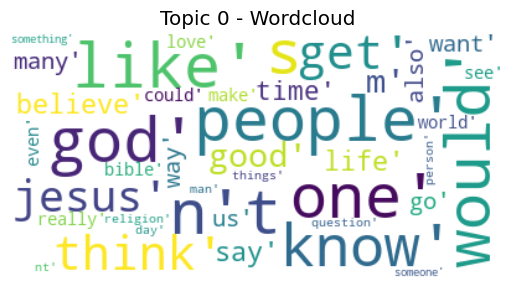

In [43]:
wordcloud_topic_0 = WordCloud(max_font_size=50, 
                               max_words=50, 
                               background_color="white").generate(str(tokens_0_t50))
plt.figure()
plt.title("Topic 0 - Wordcloud")
plt.imshow(wordcloud_topic_0, interpolation="bilinear")
plt.axis("off")
plt.show()



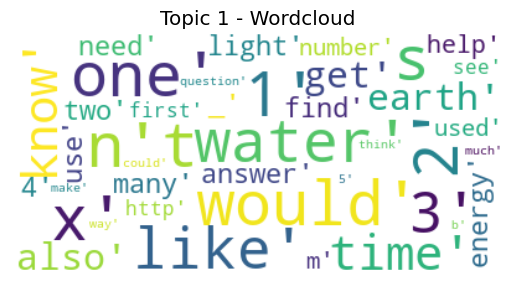

In [44]:
wordcloud_topic_1 = WordCloud(max_font_size=50, 
                               max_words=100, 
                               background_color="white").generate(str(tokens_1_t50))
plt.figure()
plt.title("Topic 1 - Wordcloud")
plt.imshow(wordcloud_topic_1, interpolation="bilinear")
plt.axis("off")
plt.show()



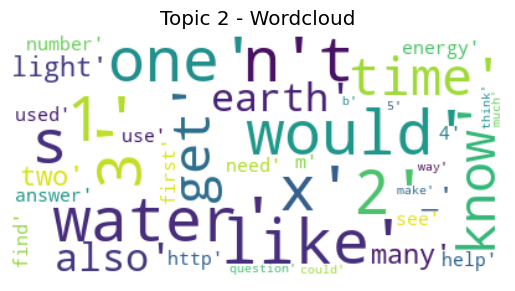

In [45]:
wordcloud_topic_2 = WordCloud(max_font_size=50, 
                               max_words=100, 
                               background_color="white").generate(str(tokens_2_t50))
plt.figure()
plt.title("Topic 2 - Wordcloud")
plt.imshow(wordcloud_topic_2, interpolation="bilinear")
plt.axis("off")
plt.show()

+ It's possible to see that some are the words are repeated among topics like 'would', 'like', 'know'

## Import Libraries 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('stopwords')
nltk.download('punkt')

from wordcloud import WordCloud

# define the stemmer and stopwords
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))


from sklearn.metrics import recall_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
import random

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vilis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vilis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vilis\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Import data

In [2]:
df_train = pd.read_csv("yahoo_train.csv")

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400000 entries, 0 to 1399999
Data columns (total 10 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   id                1400000 non-null  int64 
 1   topic             1400000 non-null  int64 
 2   question_title    1400000 non-null  object
 3   question_content  768325 non-null   object
 4   best_answer       1375421 non-null  object
 5   topic_name        1400000 non-null  object
 6   title_clean       1396823 non-null  object
 7   content_clean     764929 non-null   object
 8   answer_clean      1369225 non-null  object
 9   text_clean        1400000 non-null  object
dtypes: int64(2), object(8)
memory usage: 106.8+ MB


### Define clean dataset

+ Variables 'topic', 'topic_name' and 'text_clean'

In [6]:
df_clean = df_train[['topic','topic_name','text_clean']]

### Filtering topics

+ Filter topics 0,1,2.

In [7]:
df_clean = df_clean[df_clean.topic.isin([0,1,2])]

In [50]:
df_clean.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 420000 entries, 2 to 1399998
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   topic       420000 non-null  int64 
 1   topic_name  420000 non-null  object
 2   text_clean  420000 non-null  object
 3   noun_text   420000 non-null  object
dtypes: int64(1), object(3)
memory usage: 16.0+ MB


### Metrics

In [9]:
def get_metrics(y_trues, y_preds, verbose=True):

  recall = recall_score(y_trues, y_preds) * 100
  precision = precision_score(y_trues, y_preds) * 100

  if verbose:
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')

  return recall, precision

## Baseline models

### Ruled based model

+ Gets as inputs a dictionnary for each topic with the fifty most common words
+ For each sentence find the dictionary with more coincidences and classify the text under that topic
+ Calculate precision, recall, f1-score and the confusion matrix for the model


In [11]:
topics = df_clean.groupby('topic')['text_clean'].apply(list)

# Preprocess the text data for each topic
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(topics.apply(lambda x: ' '.join(x)))

# Extract the top 10 keywords for each topic
feature_names = tfidf.get_feature_names()
keywords = {}
for topic in topics.index:
    index = topics.index.get_loc(topic)
    feature_index = tfidf_matrix[index,:].nonzero()[1]
    tfidf_scores = zip(feature_index, [tfidf_matrix[index, x] for x in feature_index])
    sorted_scores = sorted(tfidf_scores, key=lambda x: x[1], reverse=True)
    top_keywords = [feature_names[i] for i, score in sorted_scores[:50]]
    keywords[topic] = top_keywords

print(keywords)

C:\Users\vilis\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


{0: ['god', 'people', 'would', 'one', 'like', 'know', 'think', 'get', 'jesus', 'good', 'believe', 'life', 'say', 'time', 'many', 'want', 'us', 'go', 'way', 'also', 'really', 'make', 'bible', 'love', 'see', 'even', 'world', 'could', 'question', 'religion', 'things', 'day', 'person', 'man', 'something', 'someone', 'need', 'right', 'much', 'well', 'find', 'anyone', 'help', 'first', 'said', 'never', 'thing', 'mean', 'christian', 'church'], 1: ['would', 'one', 'water', 'like', 'time', 'know', 'get', 'also', 'earth', 'light', 'two', 'many', 'energy', 'need', '10', 'answer', 'find', 'use', 'help', 'number', 'http', 'used', 'question', 'see', 'first', 'could', 'make', 'think', 'much', 'way', 'people', 'may', 'different', 'mass', 'air', 'good', 'called', 'please', 'years', 'even', 'go', 'well', 'take', 'point', 'space', 'work', 'since', 'speed', 'sun', 'www'], 2: ['get', 'like', 'know', 'help', 'good', 'one', 'would', 'also', 'go', 'weight', 'time', 'need', 'take', 'body', 'people', 'may', 'rea

In [12]:
from nltk import pos_tag
from nltk.tokenize import word_tokenize
def keep_nouns(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Get the POS tags
    pos_tags = pos_tag(tokens)
    
    # Keep only the nouns
    nouns = [word for word, pos in pos_tags if pos.startswith('N')]
    
    # Join the nouns into a single string
    preprocessed_text = ' '.join(nouns)
    
    return preprocessed_text

In [13]:
df_clean['noun_text'] = df_clean['text_clean'].apply(keep_nouns)

In [14]:
topics = df_clean.groupby('topic')['text_clean'].apply(list)

# Preprocess the text data for each topic
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(topics.apply(lambda x: ' '.join(x)))

# Extract the top 10 keywords for each topic
feature_names = tfidf.get_feature_names()
keywords = {}
for topic in topics.index:
    index = topics.index.get_loc(topic)
    feature_index = tfidf_matrix[index,:].nonzero()[1]
    tfidf_scores = zip(feature_index, [tfidf_matrix[index, x] for x in feature_index])
    sorted_scores = sorted(tfidf_scores, key=lambda x: x[1], reverse=True)
    top_keywords = [feature_names[i] for i, score in sorted_scores[:50]]
    keywords[topic] = top_keywords

print(keywords)

C:\Users\vilis\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


{0: ['god', 'people', 'would', 'one', 'like', 'know', 'think', 'get', 'jesus', 'good', 'believe', 'life', 'say', 'time', 'many', 'want', 'us', 'go', 'way', 'also', 'really', 'make', 'bible', 'love', 'see', 'even', 'world', 'could', 'question', 'religion', 'things', 'day', 'person', 'man', 'something', 'someone', 'need', 'right', 'much', 'well', 'find', 'anyone', 'help', 'first', 'said', 'never', 'thing', 'mean', 'christian', 'church'], 1: ['would', 'one', 'water', 'like', 'time', 'know', 'get', 'also', 'earth', 'light', 'two', 'many', 'energy', 'need', '10', 'answer', 'find', 'use', 'help', 'number', 'http', 'used', 'question', 'see', 'first', 'could', 'make', 'think', 'much', 'way', 'people', 'may', 'different', 'mass', 'air', 'good', 'called', 'please', 'years', 'even', 'go', 'well', 'take', 'point', 'space', 'work', 'since', 'speed', 'sun', 'www'], 2: ['get', 'like', 'know', 'help', 'good', 'one', 'would', 'also', 'go', 'weight', 'time', 'need', 'take', 'body', 'people', 'may', 'rea

In [51]:
def rule_based_model(text):
    # Extract the words from the text
    words = set(text.split())
    # Find the topic with the most matching keywords
    max_matches = 0
    best_topic = None
    for topic, topic_keywords in keywords.items():
        matches = len(words.intersection(topic_keywords))
        if matches > max_matches:
            max_matches = matches
            best_topic = topic
    if best_topic is None:
        best_topic = random.randint(0,2)
    return best_topic

In [52]:
y_pred_rule = df_clean['text_clean'].apply(rule_based_model)

In [54]:
print('Rule-based model:')
print('Accuracy Score:', accuracy_score(df_clean['topic'], y_pred_rule))
print(classification_report(df_clean['topic'], y_pred_rule))

Rule-based model:
Accuracy Score: 0.5968666666666667
              precision    recall  f1-score   support

           0       0.53      0.76      0.63    140000
           1       0.64      0.52      0.57    140000
           2       0.67      0.51      0.58    140000

    accuracy                           0.60    420000
   macro avg       0.61      0.60      0.59    420000
weighted avg       0.61      0.60      0.59    420000



In [43]:
#Confussion Matrix 

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

#Plot confusion matrix
def plot_cm(y_true, y_pred, figsize=(6,6)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = '0.0%'
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'True Values'
    cm.columns.name = 'Predicted Values'
    fig, ax = plt.subplots(figsize=figsize)
    
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

<Figure size 3000x1000 with 0 Axes>

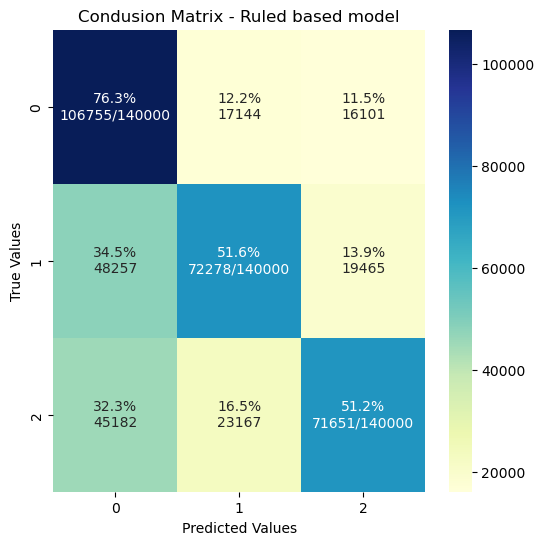

In [61]:
#Matrix
plt.figure(figsize=(30,10))
plot_cm(df_clean['topic'], y_pred_rule)
plt.title("Confusion Matrix - Ruled based model")
plt.show()

+ First approach to a clasificatio model
+ The model seems to perform better with the classification of topics related to topic 0
+ The performance decreases in a 25% for the topics 1 and 2

### TF-IDF + Logistic Regression

+ Create a bag of words with Count Vectorizer 
+ Use a TF-IDF transformer
+ Run a Logistic Regression

In [19]:
X_train, X_valid, y_train, y_valid = train_test_split(df_clean['text_clean'].tolist(), df_clean['topic'].tolist(), test_size=0.2, random_state=0, shuffle=True)

#### Create bag of words with CountVectorizer

In [20]:
vectorizer = CountVectorizer(analyzer = 'word', min_df = 10, max_df = 0.9)
X_train = vectorizer.fit_transform(X_train)
X_valid = vectorizer.transform(X_valid)

#### TF-IDF

In [21]:
tfidf_transformer = TfidfTransformer()
X_train = tfidf_transformer.fit_transform(X_train)
X_valid = tfidf_transformer.transform(X_valid)

#### LogisticRegression model

In [22]:
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

C:\Users\vilis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [41]:
lr_y_pred = lr_model.predict(X_valid)
print('LogisticRegression model:')
print('Accuracy Score:', accuracy_score(y_valid, lr_y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_valid, lr_y_pred))
print('Classification Report:\n', classification_report(y_valid, lr_y_pred))

LogisticRegression model:
Accuracy Score: 0.8778095238095238
Confusion Matrix:
 [[24903  1426  1619]
 [ 1790 24566  1752]
 [ 2198  1479 24267]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.89      0.88     27948
           1       0.89      0.87      0.88     28108
           2       0.88      0.87      0.87     27944

    accuracy                           0.88     84000
   macro avg       0.88      0.88      0.88     84000
weighted avg       0.88      0.88      0.88     84000



<Figure size 3000x1000 with 0 Axes>

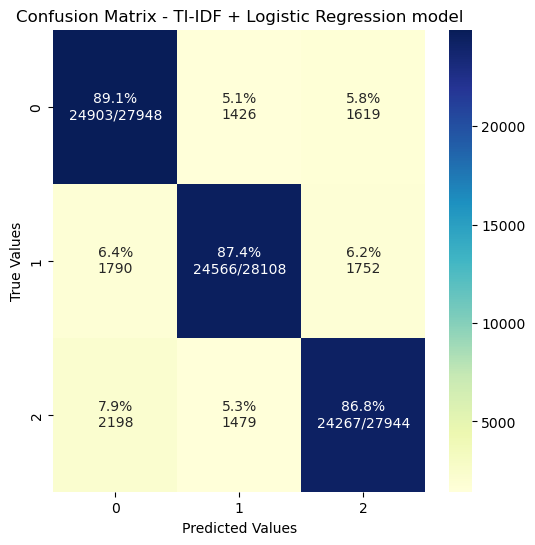

In [45]:
#Confusion Matrix
plt.figure(figsize=(30,10))
plot_cm(y_valid, lr_y_pred)
plt.title("Confusion Matrix - TI-IDF + Logistic Regression model")
plt.show()

+ Best baseline model obtained
+ Accuracy 0.88

## DecisionTree model

+ Run a Decision Tree Classifier model using the provided dataset

In [56]:
clf = DecisionTreeClassifier()

In [57]:
clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [58]:
dt_y_pred = clf.predict(X_valid)
print('DecisionTree model:')
print('Accuracy Score:', accuracy_score(y_valid, dt_y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_valid, dt_y_pred))
print('Classification Report:\n', classification_report(y_valid, dt_y_pred))

DecisionTree model:
Accuracy Score: 0.7185595238095238
Confusion Matrix:
 [[19947  3813  4188]
 [ 3826 20563  3719]
 [ 4407  3688 19849]]
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.71      0.71     27948
           1       0.73      0.73      0.73     28108
           2       0.72      0.71      0.71     27944

    accuracy                           0.72     84000
   macro avg       0.72      0.72      0.72     84000
weighted avg       0.72      0.72      0.72     84000



<Figure size 3000x1000 with 0 Axes>

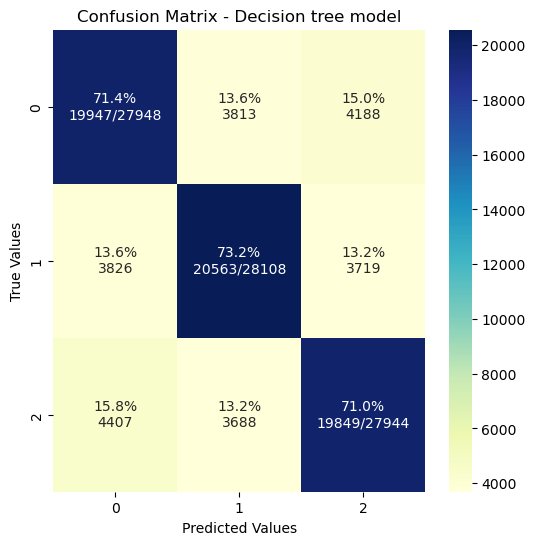

In [59]:
#Confusion Matrix
plt.figure(figsize=(30,10))
plot_cm(y_valid, dt_y_pred)
plt.title("Confusion Matrix - Decision tree model")
plt.show()

+ The obtained results are worst than the one obtained by the TF-IDF + Logistic Regression

### Error analysis

In [27]:
misclassified_texts = []
misclassified_targets = []
misclassified_predictions = []
X_valid_text = vectorizer.inverse_transform(X_valid)

for i in range(len(y_valid)):
    if y_valid[i] != lr_y_pred[i]:
        misclassified_texts.append(X_valid_text[i])
        misclassified_targets.append(y_valid[i])
        misclassified_predictions.append(lr_y_pred[i])

In [28]:
for text, target, prediction in zip(misclassified_texts, misclassified_targets, misclassified_predictions):
    print("Text:", text)
    print("True target:", target)
    print("Predicted target:", prediction)
    print()
    break

Text: ['woman' 'weight' 'us' 'taking' 'takes' 'sure' 'sexual' 'risky'
 'recommend' 'really' 'pull' 'protection' 'pill' 'nut' 'make' 'intercouse'
 'hate' 'good' 'gain' 'feeling' 'drunk' 'cons' 'condom' 'best' 'away'
 'and']
True target: 1
Predicted target: 2



+ Comparing the text and the keywords, apparently 'weight' here may be the reason it misclassified, like we saw before the word is common in all topics

In [29]:
def analyze_errors(x_test, y_test, y_pred, feature_names, num_errors=5):
    errors = []
    for i in range(len(y_test)):
        if y_pred[i] != y_test[i]:
            error = {}
            error['text'] = ' '.join([feature_names[j] for j in x_test[i].indices])
            error['true_topic'] = y_test[i]
            error['predicted_topic'] = y_pred[i]
            errors.append(error)
    sorted_errors = sorted(errors, key=lambda x: x['true_topic'])
    for error in sorted_errors[:num_errors]:
        print('Text:', error['text'])
        print('True Topic:', error['true_topic'])
        print('Predicted Topic:', error['predicted_topic'])
        print('---')

####  Print some of the examples

In [30]:
analyze_errors(X_valid, y_valid, lr_y_pred, vectorizer.get_feature_names_out(), num_errors=5)

Text: watch ve time teeth stereotypically seen said python proper people monty money like know important funny excuse dental care brits british bad
True Topic: 0
Predicted Topic: 2
---
Text: war vinci sort rotating rotate replica pulled notebooks machine look library leonardo it horse drawn da collection art arms arm
True Topic: 0
Predicted Topic: 1
---
Text: yrs year thinking somthing much first cost better baby average abut 20 000
True Topic: 0
Predicted Topic: 2
---
Text: without ways using tried times stay starving several self make low look keep hurting harmful good full finish feel family excerise even esteem eating eat dont boost better active
True Topic: 0
Predicted Topic: 2
---
Text: threw shot room permanently nut left ladies guy ever damaged child across
True Topic: 0
Predicted Topic: 2
---


##1. Import **Libraries**

In [92]:
import numpy as np
import pandas as pd
import spacy
import pickle
import itertools
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, Embedding
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


##2. Data Downloading

In [3]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [4]:
%pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 KB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 39.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 13.7 MB/s eta 0:00:00


In [5]:
from datasets import load_dataset
import pandas as pd
import json
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import string 
stop = stopwords.words('english')


def get_dataset(x):
    data = load_dataset("/content/drive/MyDrive/ColabNotebooks/tools/yahoo_answers_topics.py")
    df=pd.DataFrame(data[x])
    df['text']=df['question_title']+df['question_content']+df['best_answer']
    return df


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
# dftrain=get_dataset('train')
# # dftest=get_dataset('test')

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset yahoo_answers_topics downloaded and prepared to /root/.cache/huggingface/datasets/yahoo_answers_topics/yahoo_answers_topics/1.0.0/0edb353eefe79d9245d7bd7cac5ae6af19530439da520d6dde1c206ee38f4439. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [19]:
# def process_series(series, stop):
#     series = series.str.lower().str.replace('[^\w\s]', ' ').apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
#     return series

In [23]:
# dftrain['alltext']=dftrain['question_title']+dftrain['question_content']+dftrain['best_answer']
# # dftest['alltext']=dftest['question_title']+dftest['question_content']+dftest['best_answer']

In [24]:
# dftrain['cleanedtext']=process_series(dftrain['alltext'],stop)
# # dftest['cleanedtext']=process_series(dftest['alltext'],stop)

<ipython-input-19-28c81e8a02ee>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  series = series.str.lower().str.replace('[^\w\s]', ' ').apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
<ipython-input-19-28c81e8a02ee>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  series = series.str.lower().str.replace('[^\w\s]', ' ').apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))


In [26]:
# dftrain.to_csv('/content/drive/MyDrive/ColabNotebooks/data/train.csv')

In [27]:
# dftest.to_csv('/content/drive/MyDrive/ColabNotebooks/data/test.csv')

##3. Data Visualization

##4. Preprocessing Data

In [2]:
# # !python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")

In [3]:
df=pd.read_csv('/content/drive/MyDrive/ColabNotebooks/data/yahoo_train.csv')

In [21]:
df=df[df.topic.isin([0,1,2])]

In [22]:
df=df[df['text_clean'].convert_dtypes(convert_string=True).notnull()]

In [23]:
cleaned_data=df['text_clean'].to_list()

In [24]:
len(cleaned_data)

420000

In [25]:
b_file = open("/content/drive/MyDrive/ColabNotebooks/data/cleaned_data.pkl", "wb")
pickle.dump(cleaned_data, b_file)
b_file.close()

In [74]:
def encoding_data(cleaned_data):

    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(cleaned_data)

    # word_index is a dictionary contains indeces for the words like {'for': 8, 'is': 9, 'me': 10, ...}
    word_index = tokenizer.word_index

    # train_sequences is vectors where each vector represents a sentence
    data_sequences = tokenizer.texts_to_sequences(cleaned_data)
    data_sequences = pad_sequences(data_sequences, maxlen=10, padding="post")



    with open("/content/drive/MyDrive/ColabNotebooks/data/tokenizer.pkl","wb") as file:
        pickle.dump(tokenizer,file)

    return data_sequences, word_index
#------------------------------------------------------------------#
data_sequences, word_index = encoding_data(cleaned_data)

with open("/content/drive/MyDrive/ColabNotebooks/data/data_sequences.pkl","wb") as file:
    pickle.dump(data_sequences,file)

with open("/content/drive/MyDrive/ColabNotebooks/data/word_index.pkl","wb") as file:
    pickle.dump(word_index,file)

##5. Importing GloVe dataset

In [75]:
!pip install wget
import wget
url ='https://www.dropbox.com/s/a247ju2qsczh0be/glove.6B.100d.txt?dl=1'
wget.download(url)

def GloVe(data = 'glove.6B.100d.txt'):

  embeddings_index={}
  with open(data, encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
  return embeddings_index
#--------------------------------------------------------------------------------------------#
def embeddingWeights(word_index, max_num_words=500000):
  embeddings_index = GloVe()
  all_embs = np.stack(embeddings_index.values())
  emb_mean,emb_std = all_embs.mean(), all_embs.std()

  num_words = min(max_num_words, len(word_index))+1

  embedding_dim=len(embeddings_index['the'])
  
  embedding_weights = np.random.normal(emb_mean, emb_std, (num_words, embedding_dim))

  for word, i in word_index.items():
      if i >= max_num_words:
          break
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
          embedding_weights[i] = embedding_vector
  
  return embedding_weights, num_words

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [76]:
embedding_weights, num_words = embeddingWeights(word_index)

a_file = open("/content/drive/MyDrive/ColabNotebooks/data/embedding_wights.pkl", "wb")
pickle.dump(embedding_weights, a_file)
a_file.close()

a_file = open("/content/drive/MyDrive/ColabNotebooks/data/num_words.pkl", "wb")
pickle.dump(num_words, a_file)
a_file.close()

/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py:3553: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [77]:
# # # Importing all the variables from Google Drive
# with open('/content/drive/MyDrive/ColabNotebooks/data/cleaned_data.pkl','rb') as file:
#   cleaned_data = pickle.load(file)

# # with open('/content/drive/MyDrive/yahoo-answers-dataset/data_label.pkl','rb') as file:
# #   data_label = pickle.load(file)

# with open('/content/drive/MyDrive/ColabNotebooks/data/data_sequences.pkl','rb') as file:
#   data_sequences = pickle.load(file)

# # with open('/content/drive/MyDrive/yahoo-answers-dataset/dic.pkl','rb') as file:
# #   dic = pickle.load(file)

# # with open('/content/drive/MyDrive/yahoo-answers-dataset/label_encoder.pkl','rb') as file:
# #   label_encoder = pickle.load(file)

# with open('/content/drive/MyDrive/ColabNotebooks/data/num_words.pkl','rb') as file:
#   num_words = pickle.load(file)

# with open('/content/drive/MyDrive/ColabNotebooks/data/tokenizer.pkl','rb') as file:
#   tokenizer = pickle.load(file)

# with open('/content/drive/MyDrive/ColabNotebooks/data/word_index.pkl','rb') as file:
#   word_index = pickle.load(file)

# with open('/content/drive/MyDrive/ColabNotebooks/data/embedding_wights.pkl','rb') as file:
#   embedding_wights = pickle.load(file)

In [78]:
df['topic'].value_counts()

2    140000
1    140000
0    140000
Name: topic, dtype: int64

In [79]:
data_label=df['topic'].to_numpy()

In [80]:
data_sequences.shape,data_sequences.dtype

((420000, 10), dtype('int32'))

In [81]:
data_label.shape

(420000,)

##6. Splitting the Data

In [82]:
train_data, val_test_data, train_labels, val_test_labels = train_test_split(data_sequences, data_label,test_size = 0.2, stratify=data_label)
test_data, val_data, test_labels, val_labels = train_test_split(val_test_data, val_test_labels, test_size = 0.5, stratify=val_test_labels)

##7. Model Preparation and Training

In [83]:
model = Sequential()
model.add(Embedding(input_dim=num_words, output_dim=100, trainable=False, input_length=10, weights=[embedding_weights]))
model.add(Bidirectional(LSTM(256, return_sequences=True, recurrent_dropout=0.2, dropout=0.2), 'concat'))
model.add(Dropout(0.4))
model.add(LSTM(128, return_sequences=True, recurrent_dropout=0.2, dropout=0.2))
model.add(Dropout(0.4))
model.add(LSTM(64, return_sequences=False, recurrent_dropout=0.2, dropout=0.2))
model.add(Dropout(0.2))
model.add(Dense(64, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss ='sparse_categorical_crossentropy', optimizer = "adam", metrics = ["accuracy"])

In [84]:
print(model.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 10, 100)           45499500  
                                                                 
 bidirectional_6 (Bidirectio  (None, 10, 512)          731136    
 nal)                                                            
                                                                 
 dropout_24 (Dropout)        (None, 10, 512)           0         
                                                                 
 lstm_19 (LSTM)              (None, 10, 128)           328192    
                                                                 
 dropout_25 (Dropout)        (None, 10, 128)           0         
                                                                 
 lstm_20 (LSTM)              (None, 64)                49408     
                                                      

In [85]:
stopping = EarlyStopping(monitor='val_accuracy', patience=2, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', patience = 1, verbose = 1, factor = 0.1, min_delta=0.001, min_lr = 0.00001)

history = model.fit(train_data, train_labels, epochs = 2,
          batch_size = 1024, shuffle=True,
          validation_data=[val_data, val_labels],
          callbacks=[reduce_lr, stopping])

model.save('/content/drive/MyDrive/ColabNotebooks/data/model.h5')

Epoch 1/2
165/165 [==============================] - 994s 6s/step - loss: 0.7529 - accuracy: 0.6695 - val_loss: 0.5941 - val_accuracy: 0.7589 - lr: 0.0010
Epoch 2/2
165/165 [==============================] - 938s 6s/step - loss: 0.6004 - accuracy: 0.7564 - val_loss: 0.5681 - val_accuracy: 0.7689 - lr: 0.0010


In [86]:
model.evaluate(test_data, test_labels)

1313/1313 [==============================] - 82s 62ms/step - loss: 0.5648 - accuracy: 0.7710


[0.5648202300071716, 0.7710475921630859]

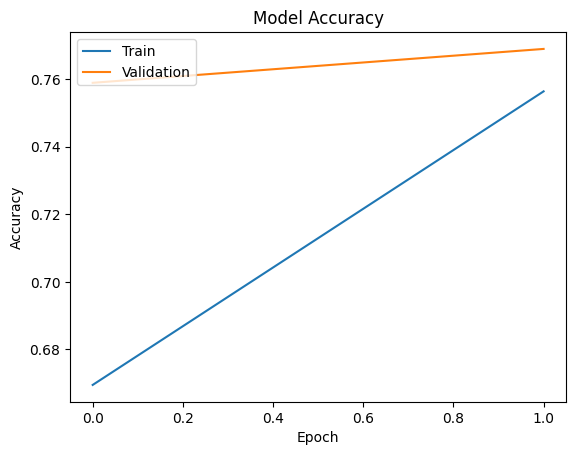

In [87]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

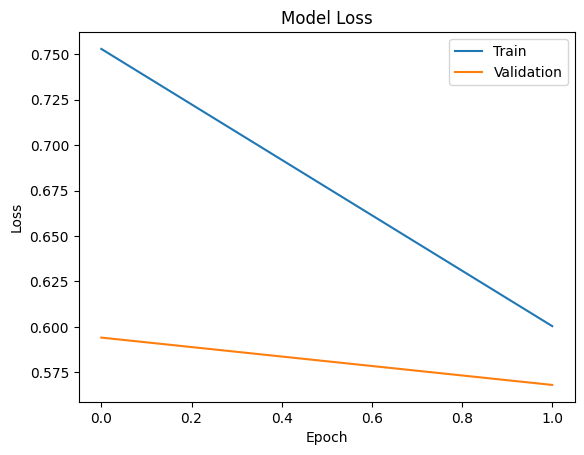

In [88]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [91]:
#getting some more metrics for the model

# predict crisp classes for test set
yhat_classes = model.predict(test_data, verbose=0)
 

array([[0.02614317, 0.03410772, 0.939749  ],
       [0.368098  , 0.04593507, 0.5859668 ],
       [0.9262358 , 0.0574751 , 0.01628915],
       ...,
       [0.13666415, 0.61301553, 0.25032035],
       [0.34697688, 0.04532418, 0.6076989 ],
       [0.00747196, 0.9841633 , 0.0083647 ]], dtype=float32)

In [95]:
yhat_classes=np.argmax(yhat_classes, axis=-1)

In [101]:

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(test_labels, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(test_labels, yhat_classes,average='macro')
print('Precision: ',precision)
# recall: tp / (tp + fn)
recall = recall_score(test_labels, yhat_classes,average='macro')
print('Recall:' , recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(test_labels, yhat_classes,average='macro')
print('F1 score:' ,f1)
 
# kappa
kappa = cohen_kappa_score(test_labels, yhat_classes)
print('Cohens kappa: %f' % kappa)

# confusion matrix
matrix = confusion_matrix(test_labels, yhat_classes)
print(matrix)

Accuracy: 0.771048
Precision:  0.7777950282419658
Recall: 0.7710476190476191
F1 score: 0.7713595806231336
Cohens kappa: 0.656571
[[11567   953  1480]
 [ 2017 10092  1891]
 [ 2484   791 10725]]


# BERT Model

Load and install necessary packages:

In [ ]:
from google.colab import drive
import numpy as np
drive.mount('/content/drive/')

import pandas as pd
!pip install ktrain
import ktrain
from ktrain import text

Mounted at /content/drive/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.3/25.3 MB 50.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 KB 61.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.4/265.4 KB 25.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 112.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.8/468.8 KB 47.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (

Read the preprocessed data in

In [ ]:
cleaned_data = pd.read_csv('/content/drive/MyDrive/yahoo_train.csv')
topic_labels = cleaned_data[['topic', 'topic_name']].drop_duplicates()
cleaned_data = cleaned_data[cleaned_data.topic.isin([0,1,2])].sample(100000).reset_index(drop=True)[['topic', 'text_clean']]

In [ ]:
# 2. Create train, validation & preprocessing datasets using texts_from_df in ktrain
(X_train, y_train), (X_test, y_test), preproc = text.texts_from_df(train_df=cleaned_data,
                                                                  text_column='text_clean',
                                                                  label_columns='topic',
                                                                  maxlen=64,
                                                                  val_pct=.3,
                                                                  preprocess_mode='bert')

# 3. Create and Train the BERT Model
model = text.text_classifier(name='bert',
                             train_data=(X_train, y_train),
                             preproc=preproc,
                             multilabel=True) 

# 4. Setting up learner
learner = ktrain.get_learner(model=model,
                             train_data=(X_train, y_train),
                             val_data=(X_test, y_test),
                             batch_size=64)

# 5. Fitting model using one-cycle poliy, lr=2e-5 from research paper
learner.fit_onecycle(lr=2e-5, epochs=3); 
     
# 6. Get predictor using preproc dataset
predictor = ktrain.get_predictor(learner.model, preproc)   
     
classes = predictor.get_classes()  
classes

['topic_0', 'topic_1', 'topic_2']
       topic_0  topic_1  topic_2
56650      0.0      0.0      1.0
97354      0.0      0.0      1.0
92072      0.0      1.0      0.0
59558      1.0      0.0      0.0
72244      1.0      0.0      0.0
['topic_0', 'topic_1', 'topic_2']
       topic_0  topic_1  topic_2
45915      0.0      1.0      0.0
25985      1.0      0.0      0.0
49769      0.0      1.0      0.0
46840      1.0      0.0      0.0
42118      0.0      1.0      0.0
downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


Is Multi-Label? True
maxlen is 64


/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


done.


begin training using onecycle policy with max lr of 2e-05...
Epoch 1/3
1094/1094 [==============================] - 1120s 1s/step - loss: 0.2525 - accuracy: 0.8490 - val_loss: 0.1867 - val_accuracy: 0.8905
Epoch 2/3
1094/1094 [==============================] - 1103s 1s/step - loss: 0.1722 - accuracy: 0.9018 - val_loss: 0.1784 - val_accuracy: 0.8956
Epoch 3/3
1094/1094 [==============================] - 1106s 1s/step - loss: 0.1194 - accuracy: 0.9354 - val_loss: 0.1911 - val_accuracy: 0.8959


['topic_0', 'topic_1', 'topic_2']

Now that we've fitted our model, we can predict the test set and assess the performance of our model

In [ ]:
predictions = learner.model.predict(X_test)
class_predictions = np.argmax(predictions, axis=1)
y_class = np.argmax(y_test, axis=1)

array([[4.6023380e-02, 9.5233226e-01, 9.0094805e-03],
       [9.7502202e-01, 9.5482310e-03, 1.1223157e-02],
       [2.4972005e-02, 9.6956015e-01, 2.3645319e-03],
       ...,
       [3.8061517e-01, 3.6410716e-01, 1.5037602e-01],
       [9.9849224e-01, 1.9386645e-03, 9.1922254e-04],
       [2.0222745e-03, 2.8279493e-02, 9.6904880e-01]], dtype=float32)

In [ ]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score

precision, recall, fscore, support = score(y_class, class_predictions)

print('Avg precision: {}'.format(precision.mean()))
print('Avg recall: {}'.format(recall.mean()))
print('Avg fscore: {}'.format(fscore.mean()))
print('support: {}'.format(support))

print('Avg accuracy: {}'.format(accuracy_score(y_class, class_predictions)))

Avg precision: 0.8960835003463217
Avg recall: 0.8958970820020138
Avg fscore: 0.8958863355448555
support: [10039 10071  9890]
Avg accuracy: 0.8958666666666667


Heatmap of classification

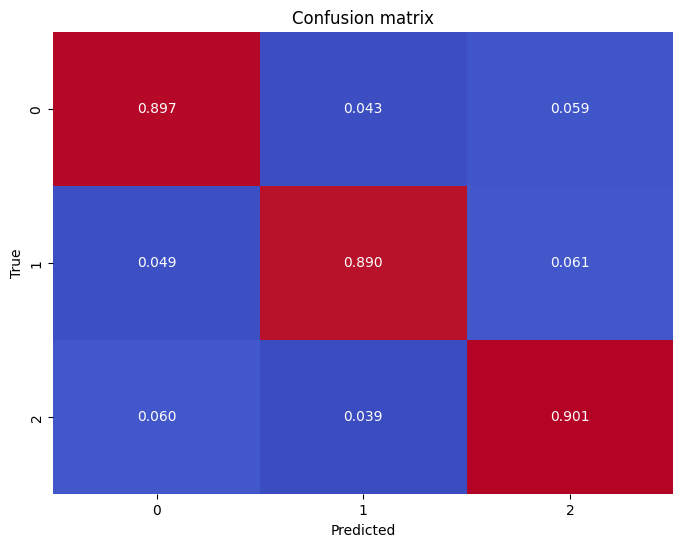

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_test, y_predicted):
    cm = confusion_matrix(y_test, y_predicted)
    cm_proportions = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_proportions, annot=True, cmap='coolwarm', fmt='.3f', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion matrix')
    plt.show()

plot_confusion_matrix(y_class, class_predictions)

Test prompts

In [ ]:
topics = topic_labels[topic_labels.topic.isin([0,1,2])].sort_values('topic').reset_index(drop=True)


,topic,topic_name
0,0,Society & Culture
1,1,Science & Mathematics
2,2,Health


In [ ]:
a_question = "my head hurts, should I see a doctor?"
another_question = "who do you think will win the best actor at the oscars this year?"
final_question = "If you wish to make an apple pie from scratch, you must first invent the universe"

print(a_question)
print(predictor.predict(a_question))
print('most likely topic:', topics.topic_name[np.argmax(list(dict(predictor.predict(a_question)).values()))])

print(another_question)
print(predictor.predict(another_question))
print('most likely topic:', topics.topic_name[np.argmax(list(dict(predictor.predict(another_question)).values()))])

print(final_question)
print(predictor.predict(final_question))
print('most likely topic:', topics.topic_name[np.argmax(list(dict(predictor.predict(final_question)).values()))])

topics

my head hurts, should I see a doctor?
[('topic_0', 0.01770344), ('topic_1', 0.022975363), ('topic_2', 0.96985406)]
most likely topic: Health
who do you think will win the best actor at the oscars this year?
[('topic_0', 0.9123698), ('topic_1', 0.10343975), ('topic_2', 0.014000283)]
most likely topic: Society & Culture
If you wish to make an apple pie from scratch, you must first invent the universe
[('topic_0', 0.107348755), ('topic_1', 0.8772431), ('topic_2', 0.008619145)]
most likely topic: Science & Mathematics


,topic,topic_name
0,0,Society & Culture
1,1,Science & Mathematics
2,2,Health


In [ ]:
example_predictions = predictor.predict([a_question,another_question,final_question])
# Convert list of tuples to dictionary
dict_output = [{t[0]: t[1] for t in row} for row in example_predictions]

# Create DataFrame from dictionary
output_df = pd.DataFrame(dict_output).set_axis([a_question,another_question,final_question], axis=0).rename(columns={'topic_0': 'Society & Culture', 'topic_1': 'Science & Mathematics', 'topic_2': 'Health'})
output_df['Highest Probability'] = output_df.apply(lambda x: topics.topic_name[np.argmax(x)], axis=1)

In [ ]:
output_df

,Society & Culture,Science & Mathematics,Health,Highest Probability
"my head hurts, should I see a doctor?",0.017703,0.022975,0.969854,Health
who do you think will win the best actor at the oscars this year?,0.912370,0.103440,0.014000,Society & Culture
"If you wish to make an apple pie from scratch, you must first invent the universe",0.107349,0.877243,0.008619,Science & Mathematics
